Install missing required packages

In [48]:
!conda install -c conda-forge xgboost shap -y


CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/conda-forge/win-64/current_repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
'https://conda.anaconda.org/conda-forge/win-64'




Import packages used throughout notebook

In [2]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# Regression

## Data Preparation
We are going to create a function that splits our data into a training set and a test set. 80% of the data will be used for the training set and the remaining 20% will be used for the test set.

In [3]:
from sklearn.model_selection import train_test_split
def prepare_data(data, target):
    # Seperate the predictor variables (X) from the target variable (y) and into their own dataframes
    X = data.drop(target, axis=1)
    y = data[target]
    
    # Create a training and test set for the predictor and target variables
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
    
    return X_train, X_test, y_train, y_test

We will load in our salary data and name the dataframe salary_data. We will also see what the data looks like by typing in our dataframe name on the line beneath the code to load in the data. This way we can get a snippet of the data to understand what it looks like. Run the cell below to load in the salary data and see what the data looks like.

In [4]:
salary_data = pd.read_csv('Salary.csv')
salary_data

,Profession,Rank,Equipment,Insalubrity,Size_Production,Salary
0,Metal heater,7,Heating furnaces,22,580,26020.00000
1,Metal heater,6,Heating furnaces,22,580,22980.00000
2,Metal heater,5,Heating furnaces,22,580,20350.00000
3,Metal heater,5,Heating furnaces,22,580,20350.00000
4,Metal heater,4,Heating furnaces,22,580,18090.00000
...,...,...,...,...,...,...
259,Quality controller,7,Control and measuring equipment,0,1180,26342.23529
260,Quality controller,7,Control and measuring equipment,0,1080,25044.58824
261,Quality controller,7,Control and measuring equipment,0,780,22060.00000
262,Quality controller,7,Control and measuring equipment,0,1020,24266.00000


## Categorical Encoding
Now we will use Label Encoding to convert our categorical variables (Profession and Equipment) to numerical variables. This is done so the ML model can make sense of the categorical variables. Run the cell below to categorically encode these variables and see what the dataset looks like after.

In [5]:
from sklearn.preprocessing import LabelEncoder
profession_encoder = LabelEncoder()
salary_data['Profession'] = profession_encoder.fit_transform(salary_data['Profession'])

equipment_encoder = LabelEncoder()
salary_data['Equipment'] = equipment_encoder.fit_transform(salary_data['Equipment'])

salary_data

,Profession,Rank,Equipment,Insalubrity,Size_Production,Salary
0,2,7,2,22,580,26020.00000
1,2,6,2,22,580,22980.00000
2,2,5,2,22,580,20350.00000
3,2,5,2,22,580,20350.00000
4,2,4,2,22,580,18090.00000
...,...,...,...,...,...,...
259,5,7,1,0,1180,26342.23529
260,5,7,1,0,1080,25044.58824
261,5,7,1,0,780,22060.00000
262,5,7,1,0,1020,24266.00000


## Splitting Data
Now we will prepare our data by splitting it into training and test sets using the function we made earlier. In order to understand exactly what this function does, we will also see what the X_train, y_train, X_test, y_test datasets in that order. You will notice that the X_train and X_test datasets are all the predictor variables and the y_test and y_train datset is the target variable (Salary).

In [6]:
X_train, X_test, y_train, y_test = prepare_data(salary_data, 'Salary')
display(X_train,y_train,X_test,y_test)

,Profession,Rank,Equipment,Insalubrity,Size_Production
173,8,3,4,18,1080
139,4,4,5,8,1400
135,0,3,4,18,1400
123,2,5,2,22,1400
179,4,4,5,8,1080
49,8,4,3,18,820
241,0,3,0,0,790
149,8,4,3,18,1180
174,1,4,4,16,1080
84,2,4,2,22,1250


173    17067.88235
139    20141.47059
135    19360.58824
123    25652.64706
179    17481.70588
49     17370.00000
241    12180.00000
149    20112.88235
174    18921.70588
84     21414.70588
114    17841.17647
71     26175.88235
40     26020.00000
108    23378.82353
200    28226.00000
69     20279.11765
57     17830.00000
195    15420.00000
236    19630.00000
43     20350.00000
205    19503.00000
142    23531.58824
53     15420.00000
225    18090.00000
16     19630.00000
39     15570.00000
256    27250.58824
251    12180.00000
82     24206.47059
141    26672.11765
197    17830.00000
58     17830.00000
217    19469.00000
153    17784.35294
136    24932.64706
11     22260.00000
119    16401.17647
172    19281.70588
55     15420.00000
255    26601.76471
6      16110.00000
148    25952.11765
124    22661.47059
86     19434.70588
193    15420.00000
262    24266.00000
19     15570.00000
147    29582.23529
230    25300.00000
252    22060.00000
189    17370.00000
250    13398.00000
Name: Salary

,Profession,Rank,Equipment,Insalubrity,Size_Production
150,7,7,4,18,1180
239,4,4,5,8,810
37,4,5,5,8,790
88,7,6,3,18,1250
169,8,4,3,18,1080
...,...,...,...,...,...
118,4,5,5,8,950
93,8,3,4,18,1250
192,8,4,4,18,780
28,7,6,3,18,790


150    29582.23529
239    15570.00000
37     17830.00000
88     26735.29412
169    19281.70588
          ...     
118    18794.11765
93     18285.88235
192    17370.00000
28     22260.00000
201    24882.00000
Name: Salary, Length: 212, dtype: float64

## Linear Regression Model
Now we will run a linear regression model on our prepared dataset below. We will evaluate this model with 4 metrics: mean absolute error, mean squared error, root mean squared error and the R2 score. Run the cell below to create the model, train it, and generate predictions.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = LinearRegression() # create model
model.fit(X_train, y_train) # train model
pred = model.predict(X_test) # generate predictions

Let's take a look at a sample prediction by our model. Run the cell below to look at the input, the predicted salary, the actual salary, and the error.

In [8]:
import math

print(f"Input:\n{X_test.iloc[0]}\n")
print(f"Predicted salary: ${pred[0]}")
print(f"Actual salary: ${y_test.iloc[0]}")
print(f"Absolute error: ${abs(pred[0] - y_test.iloc[0])}")
print(f"Squared error: {(pred[0] - y_test.iloc[0]) ** 2}")

Input:
Profession            7
Rank                  7
Equipment             4
Insalubrity          18
Size_Production    1180
Name: 150, dtype: int64

Predicted salary: $28453.28355726066
Actual salary: $29582.235289999997
Absolute error: $1128.9517327393369
Squared error: 1274532.014855151


The cell below will evaluate the model with the 4 metrics, and print the equation of the model. 

In [9]:
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

coef = model.coef_
intercept = model.intercept_
cols = X_train.columns

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2: {r2}")
print(f"\nEquation for Regression Model:")
print(f"Salary = {coef[0]}({cols[0]}) + {coef[1]}({cols[1]}) + {coef[2]}({cols[2]}) + {coef[3]}({cols[3]}) + {coef[4]}({cols[4]})")

Mean Absolute Error: 569.0558279845924
Mean Squared Error: 528800.8097868622
Root Mean Squared Error: 727.1869153022916
R2: 0.9714660051614242

Equation for Regression Model:
Salary = 44.14643015452422(Profession) + 2714.3208307333234(Rank) + -127.47793488716364(Equipment) + 159.57933514004694(Insalubrity) + 6.994004105928258(Size_Production)


# Binary Classification (Credit)

## Naive Rule
We want to understand what the accuracy of a Naive Rule Model is, so we create a simple function to get us the accuracy for it. This is a simple and effective way to rule out any ML model that does not make value adding predictions.

In [10]:
def naive_rule_accuracy(y_train, y_test):
    majority_class = y_train.value_counts().idxmax()

    test_counts = y_test.value_counts()
    accuracy_naive = test_counts[majority_class] / test_counts.sum()

    print(f"The accuracy of the Naive Model is: {accuracy_naive}")

## Model Evaluation
We want to create a function to automatically evaluate our models. We will be looking at accuracy, recall, percision, f1-score, confusion matrix and the ROC Curve

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

def evaluate(model, X_test, y_test):
    pred = model.predict(X_test)
    # accuracy = correct_predictions / all_predictions 
    acc = accuracy_score(y_test, pred)

    # true_positives / (true_positives + false_postives)
    # how many positive predictions were true
    prec = precision_score(y_test, pred, average='weighted')

    # true_postives / (true_positives + false_negatives)
    # how many postives out of all were identified
    rec = recall_score(y_test, pred, average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, pred, average='weighted')
    
    print(f"accuracy: {acc}")
    print(f"precision: {prec}")
    print(f"recall: {rec}")
    print(f"f1: {f1}")
    
    try:
        prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, prob, multi_class='ovo')
        print(f"roc_auc: {roc_auc}")
    except:
        pass
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(model, X_test, y_test, xticks_rotation='vertical', ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_ylabel('Actual labels')

    
    

## Data Preparation
We will now look at credit data for another Binary Classification problem. We will load in the data as credit_data, veiw it and then split it similarly to the rice dataset. For this dataset we will be looking at payment history patterns for customers (the CustomerID field has been removed for anonymity) and try to predict if they will be credit risks or not.

In [12]:
credit_data = pd.read_csv('Company.csv')
credit_data

,MPD_AUG_2021,MPD_JUL_2021,MPD_JUN_2021,MPD_MAY_2021,MPD_APR_2021,MPD_MAR_2021,MPD_FEB_2021,MPD_JAN_2021,Average_Payment_Days,"('total_counts', '0')","('total_counts', '1-30')","('total_counts', '31-60')","('total_counts', '61-90')","('total_counts', '90+')",Risk
0,0,0,0,0,0,8,0,0,8,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,15,0,0,15,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,113,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103771,20,0,22,0,0,0,0,0,21,2,7,7,0,0,0
103772,7,7,27,10,0,0,0,0,13,2,16,4,0,0,0
103773,0,0,0,26,0,0,0,0,26,0,1,0,0,0,0
103774,0,15,26,0,0,0,0,0,20,2,6,3,0,0,0


In [13]:
X_train, X_test, y_train, y_test = prepare_data(credit_data, 'Risk')

## Naive Rule Benchmark
Before we do any ML, lets look at the Naive Model accuracy. If a model cant beat the accuracy of the Naive Model, then there is no point in looking at it further.

In [14]:
naive_rule_accuracy(y_train, y_test)

The accuracy of the Naive Model is: 0.8131436624468508


# Logistic Regression Model
Now lets run the model, like we did above and see if we get an improved output from the naive rule.

accuracy: 0.9999759097095916
precision: 0.9999759128150109
recall: 0.9999759097095916
f1: 0.9999759103075685


[Text(0, 0, 'Low Risk'), Text(0, 1, 'High Risk')]

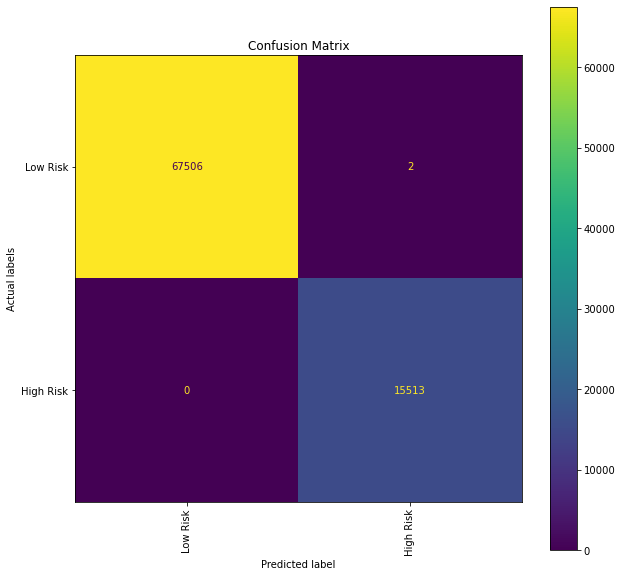

In [15]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

fig = plt.gcf()
ax = plt.gca()

ax.xaxis.set_ticklabels(['Low Risk','High Risk'])
ax.yaxis.set_ticklabels(['Low Risk','High Risk'])

Run the cell below to see how many false positives and false negatives there were

In [16]:
pred = model.predict(X_test)
false_positives = 0
false_negatives = 0
for prediction, truth in zip(pred, y_test):
    if truth == 1 and prediction == 0:
        false_negatives += 1
    if truth == 0 and prediction == 1:
        false_positives += 1

print(f"False Positives: {false_positives}")
print(f"False negatives: {false_negatives}")

False Positives: 2
False negatives: 0


Run the cell below to see what the ROC_AUC score was

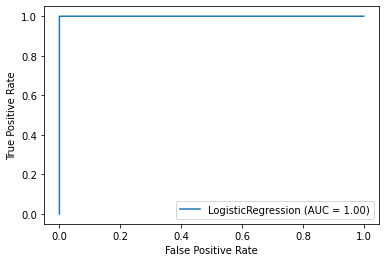

In [17]:
from sklearn.metrics import roc_curve, plot_roc_curve
roc_curve(y_test, model.predict_proba(X_test)[:,1])
plot_roc_curve(model, X_test, y_test)

# Binary Classification (Rice)

## Data Preperation
Like all the previous dataset we will load in our rice data as rice_data. We will use this dataset to predict if the rice is Jasmine or is Gonen. (1 = Jasmine, 0 = Gonen). We will load in the data and then split it into training and test sets. 

In [18]:
rice_data = pd.read_csv('rice.csv')
rice_data

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229317,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...
18180,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [19]:
X_train, X_test, y_train, y_test = prepare_data(rice_data, 'Class')

## Naive Rule Benchmark
Before we do any ML, lets look at the Naive Model accuracy. If a model cant beat the accuracy of the Naive Model, then there is no point in looking at it further.

In [20]:
naive_rule_accuracy(y_train, y_test)

The accuracy of the Naive Model is: 0.5463981303271928


## Logistic Regression Model
Now lets run a Logistic Regression Model and produce some evaluation metrics and the confusion matrix.

accuracy: 0.9865273577124003
precision: 0.9865756151524954
recall: 0.9865273577124003
f1: 0.9865198097197893


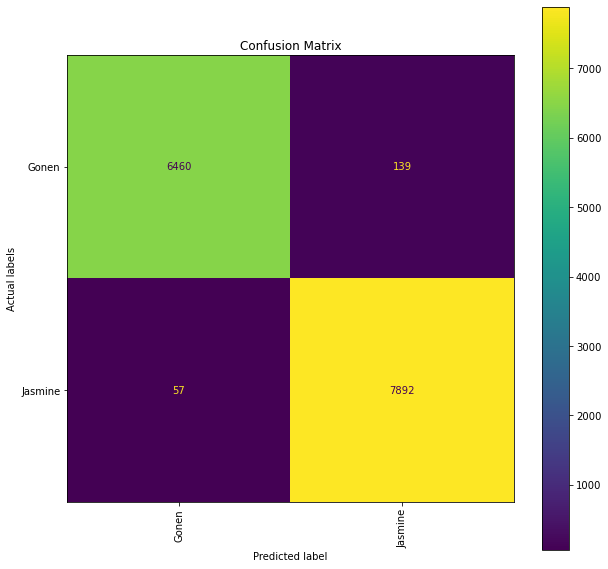

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

fig = plt.gcf()
ax = plt.gca()

ax.xaxis.set_ticklabels(['Gonen','Jasmine']); ax.yaxis.set_ticklabels(['Gonen','Jasmine']);

The cell below display's the ROC_AUC score and graph.

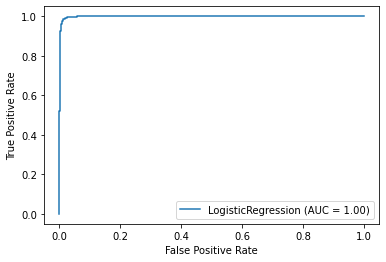

In [22]:
from sklearn.metrics import roc_curve, plot_roc_curve
roc_curve(y_test, model.predict_proba(X_test)[:,1])
plot_roc_curve(model, X_test, y_test)

# Classification (Crop Recommendation)

## Data Preparation
Now we will import the crop.csv dataset as crop_data. We will use this dataset to better predict the 'label' colunm. Run the cell below to see what the dataset looks like after it has been loaded.

In [23]:
crop_data = pd.read_csv('crops.csv')
crop_data

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


Just like the heart dataset, we will now split this dataset into training and test sets. If you would like to see what these datasets look like, run the cell, open another cell below them and type in the name(s) of the dataset(s) you wish to see (see similar example with heart_data above).

In [24]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

## Naive Rule Benchmark
Before we do any ML, lets look at the Naive Model accuracy. If a model cant beat the accuracy of the Naive Model, then there is no point in looking at it further. The Naive Rule Benchmark for this problem will be very low, given it is a multi-class problem.

In [25]:
naive_rule_accuracy(y_train, y_test)

The accuracy of the Naive Model is: 0.040340909090909094


## Naive Bayes Model
We will first use the Naive Bayes Model on our dataset. We are using the Gaussian Naive Bayes Model as our predictor variables are continous and not discrete. Click the cell below to run it and get a confusion matrix, as well as the accuracy, percision, recall, f1 score and roc_auc.

accuracy: 0.9903409090909091
precision: 0.9906995602229077
recall: 0.9903409090909091
f1: 0.9903313551338887
roc_auc: 0.9999446935774637


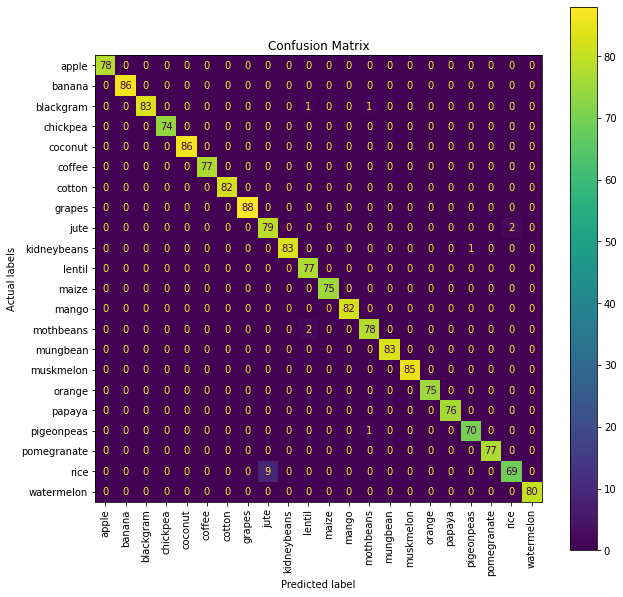

In [26]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Sochastic Gradient Descent Model
Now we will be running the Sochastic Gradient Descent Model. Click the cell below to produce the output and evaluate the model.

C:\Users\gu01042270\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.7045454545454546
precision: 0.7610944392021467
recall: 0.7045454545454546
f1: 0.686041292695661


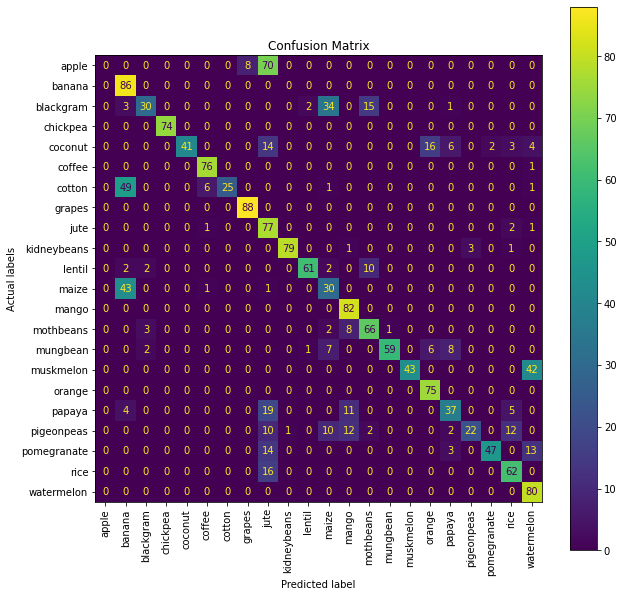

In [27]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Perceptron Model
Now we will be running the Sochastic Gradient Descent Model. Click the cell below to produce the output and evaluate the model.

C:\Users\gu01042270\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.6738636363636363
precision: 0.7587980050736141
recall: 0.6738636363636363
f1: 0.6438446293989596


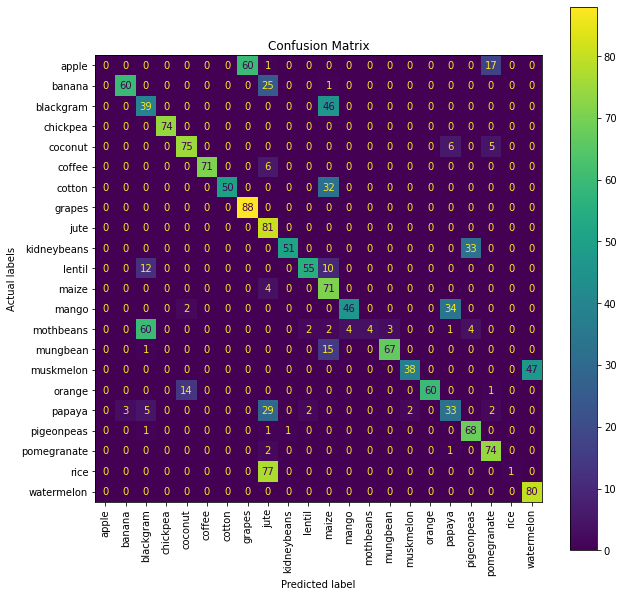

In [28]:
from sklearn.linear_model import Perceptron
model = Perceptron()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Decision Tree Model
Now we will be running a Decision Tree Model. Click the cell below to produce the output and evaluate the model.

accuracy: 0.9488636363636364
precision: 0.9539899175075182
recall: 0.9488636363636364
f1: 0.9483310276269292
roc_auc: 0.9734618465214613


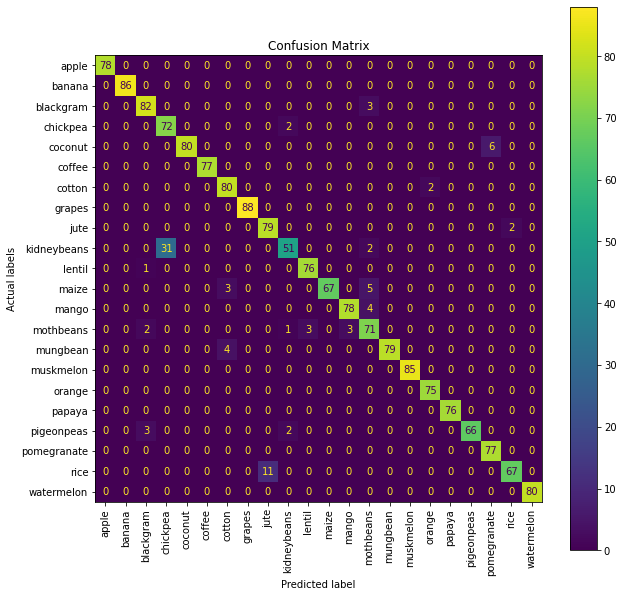

In [29]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## XGBoost Model
Now we will be running a XGBoost Model. Click the cell below to produce the output and evaluate the model.

C:\Users\gu01042270\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:08:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.9517045454545454
precision: 0.9561805421039302
recall: 0.9517045454545454
f1: 0.9516701571982435
roc_auc: 0.9993198519525078


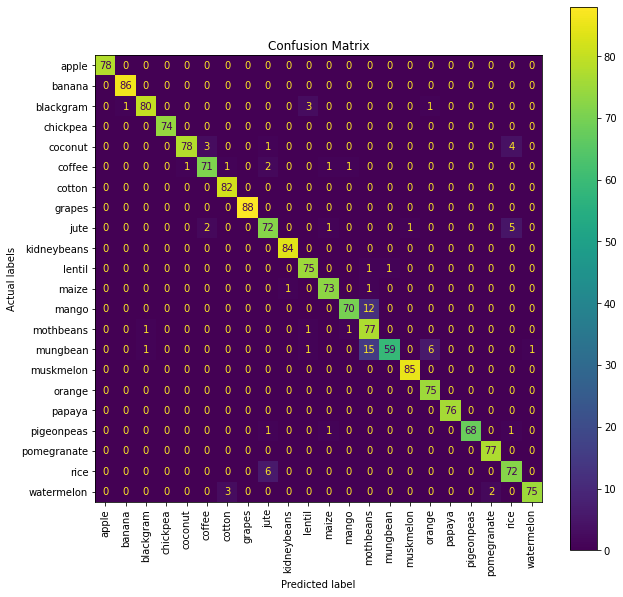

In [30]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

# Hyperparameter Tuning
We will use python to optimize the hyperparameters of our SGD Classifier. We want to see if through hyperparameter tuning we can improve the performance of the model. We will be using the same crop dataset as we used for the first SGD Model, so we will start by splitting the dataset again. 

In [31]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

Now let us write in the hyperparameter tuning function. In the param_grid we will be defining the various parameters we discussed in the slide. Run the 2 cells below to tune the model hyperparameters, the cells following will display the results of the tuning.

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "penalty": ['l1', 'l2', 'elasticnet'], # The various options to put a penalty on errors (also known as regularization)
    "alpha": [0.0001, 0.001, 0.01], # The constant that multiplies the regularization term. The higher the value the, the stronger the penalty
    "eta0": [0.001, 0.01, 0.1], # The initial learning rate for the model. Will change with adaptive learning
    "learning_rate": ['constant', 'adaptive'] # Does the model keep the learning rate constant or change as it runs 
}
grid_cv = GridSearchCV(SGDClassifier(), param_grid, n_jobs=-1, cv=5, scoring="f1_weighted")
# n_jobs = means the number of jobs to run in parallel, -1 means use all processors
# cv = cross validation, how many folds
# scoring = what we will be scoring the model on, in our case it will be the weighted f1 score.

In [33]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'eta0': [0.001, 0.01, 0.1],
                         'learning_rate': ['constant', 'adaptive'],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1_weighted')

Run the cell below to see what is the best score produced by the optimal set of hyperparameters.

In [34]:
grid_cv.best_score_

0.7670401675984679

Run the cell below to find out which combination of hyperparameters turned out to be the best.

In [35]:
grid_cv.best_params_

{'alpha': 0.001,
 'eta0': 0.001,
 'learning_rate': 'adaptive',
 'penalty': 'elasticnet'}

Run both the cells below to evaluate the model with the optimal set of hyperparameters and see what the performance stats look like above. You will notice a significant improvement in the accuracy of the model.

In [36]:
model = grid_cv.best_estimator_

accuracy: 0.7579545454545454
precision: 0.8772454293876139
recall: 0.7579545454545454
f1: 0.7839412629868203


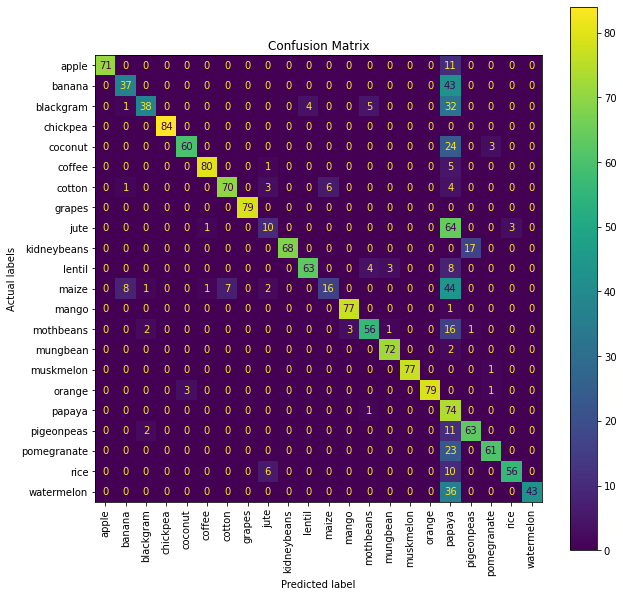

In [37]:
evaluate(model, X_test, y_test)

# Feature Scaling
We want to see if our model preforms any better if we standardize or normalize the data. Just like before we will be using our crop data and splitting into training and test sets. We will be using the same SGD classifier because that model had some room for improvement. We want to see if either standardization or normalization will improve the model.

## Data Prep
First step is to split the data into training and test sets

In [38]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

Now we will scale the data. We are going to both normalize the data and standardize it.

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = crop_data.drop("label", axis=1)
y = crop_data["label"]

standard_scaler = StandardScaler()
standard_scaler.fit(X)
X_s_scaled = pd.DataFrame(standard_scaler.transform(X), columns=X.columns)

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X)
X_mm_scaled = pd.DataFrame(minmax_scaler.transform(X), columns=X.columns)
with pd.option_context('display.float_format', lambda x: '%.3f' % x):  
    print("Unscaled Data:") 
    display(X.describe())
    print("Standardized Data:")
    display(X_s_scaled.describe())
    print("Normalized Data:")
    display(X_mm_scaled.describe())

Unscaled Data:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000
mean,50.552,53.363,48.149,25.616,71.482,6.469,103.464
std,36.917,32.986,50.648,5.064,22.264,0.774,54.958
min,0.000,5.000,5.000,8.826,14.258,3.505,20.211
25%,21.000,28.000,20.000,22.769,60.262,5.972,64.552
50%,37.000,51.000,32.000,25.599,80.473,6.425,94.868
75%,84.250,68.000,49.000,28.562,89.949,6.924,124.268
max,140.000,145.000,205.000,43.675,99.982,9.935,298.560


Standardized Data:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000
mean,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.370,-1.466,-0.852,-3.317,-2.571,-3.832,-1.515
25%,-0.801,-0.769,-0.556,-0.562,-0.504,-0.643,-0.708
50%,-0.367,-0.072,-0.319,-0.003,0.404,-0.057,-0.156
75%,0.913,0.444,0.017,0.582,0.830,0.587,0.379
max,2.423,2.779,3.098,3.567,1.280,4.479,3.551


Normalized Data:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000,2200.000
mean,0.361,0.345,0.216,0.482,0.668,0.461,0.299
std,0.264,0.236,0.253,0.145,0.260,0.120,0.197
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.150,0.164,0.075,0.400,0.537,0.384,0.159
50%,0.264,0.329,0.135,0.481,0.772,0.454,0.268
75%,0.602,0.450,0.220,0.566,0.883,0.532,0.374
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Unscaled Data
We are going to run the same model on the three datasets above and see which one comes out with the best performance. All of them are SGD Models and we will see the confusion matrix, accuracy, percision, recall and the f1 score.

C:\Users\gu01042270\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.7
precision: 0.7927332144979203
recall: 0.7
f1: 0.697183232154554


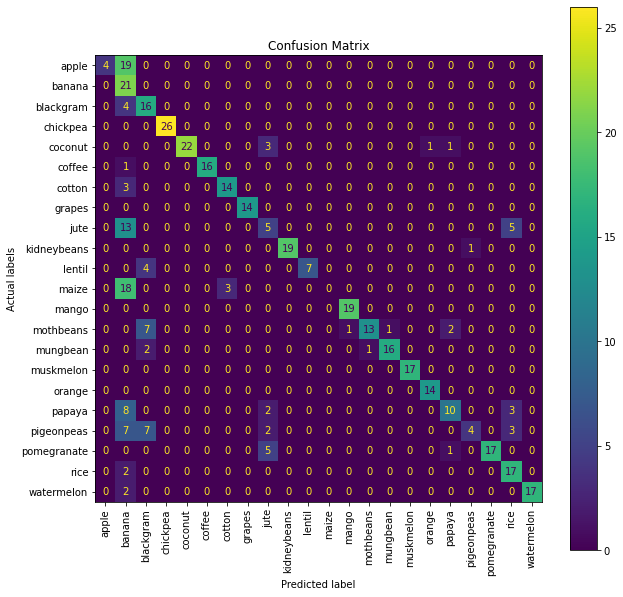

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Standardized Data

accuracy: 0.8545454545454545
precision: 0.9391403318903319
recall: 0.8545454545454545
f1: 0.868926067041394


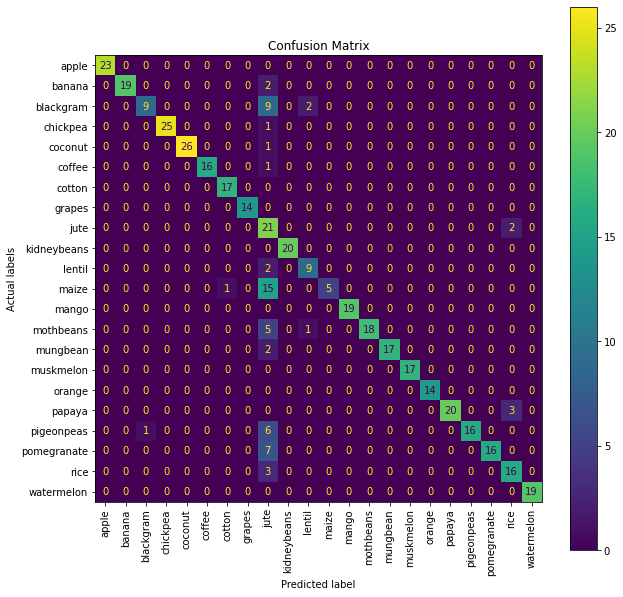

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_s_scaled, y, test_size=0.2, random_state=42)
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Normalized Data

accuracy: 0.9
precision: 0.9227280902908893
recall: 0.9
f1: 0.9002477342500247


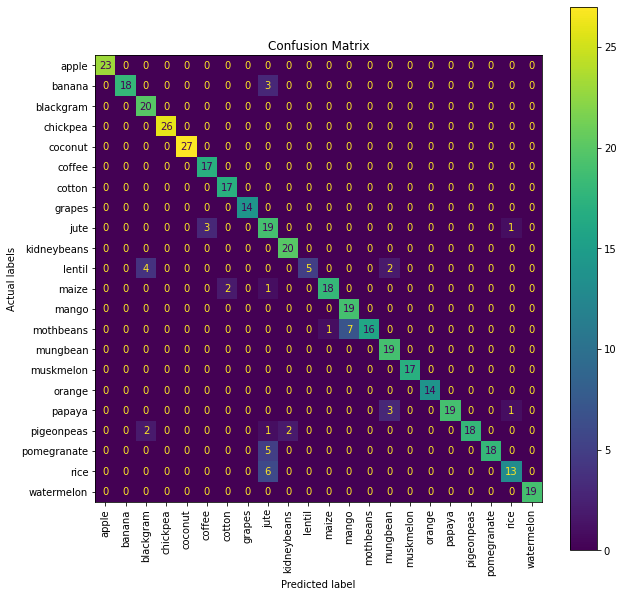

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_mm_scaled, y, test_size=0.2, random_state=42)
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

# SHAP Values
To understand the importance of predictor variable will have on the outcome, we can use the SHAP package in python. We want to know how the predictors affect the outcome for our crop dataset with an XGBoost model so we will first train an XGBoost Model with that data again then see the shap values.

In [43]:
import shap

Split the dataset into training and test sets, like before.

In [44]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

Let us now train and evaluate the model, same as we did once before.

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:08:51] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.9511363636363637
precision: 0.9539977772779182
recall: 0.9511363636363637
f1: 0.9510879777692949
roc_auc: 0.9987340139779393


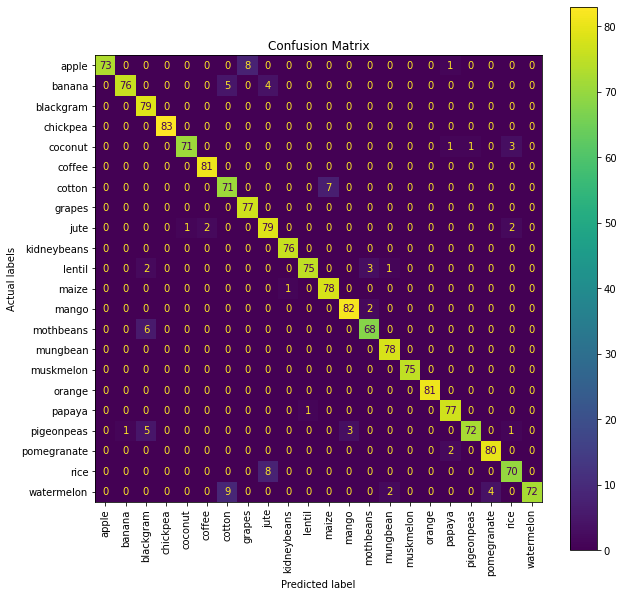

In [45]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

Run the two cell below to calculate the SHAP values. It may take a couple minutes to complete.

In [46]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

Run the cell below to see a bar plot of the SHAP values for each outcome. You will notice that after a comma there is a number from 0 - 21. That number represents one of the 22 outcomes the target variable could take and the graph will represent the importance of the features that will lead to that specific outcome. To see how the SHAP values change with each target class, change the number from what is with anything in between 0 and 21.

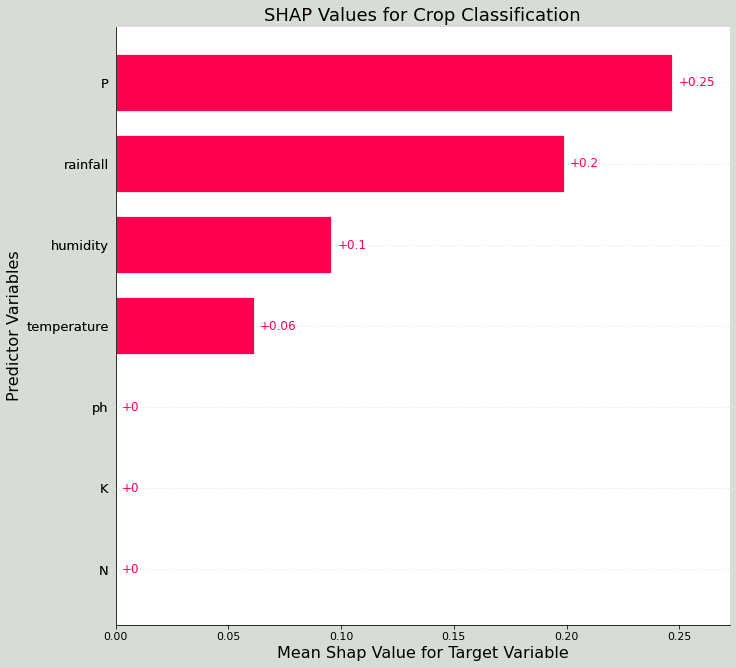

In [47]:
shap.plots.bar(shap_values[...,21], show=False)
fig = plt.gcf()
ax = plt.gca()
fig.set_figheight(11)
fig.set_figwidth(11)
font_dict = {'size':16}
font_dict_title = {'size':18}
fig.patch.set_facecolor('xkcd:light grey')
plt.xlabel('Mean Shap Value for Target Variable',font_dict)
plt.ylabel('Predictor Variables', font_dict)
plt.title('SHAP Values for Crop Classification', font_dict_title)
plt.show()